In [1]:
import os
import tqdm as tqdm
import numpy as np
import pandas as pd
import fastcluster
from scipy.cluster.hierarchy import fcluster
import pyRMT
import sklearn
from pyRMT import optimalShrinkage
import bahc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as linalg
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
from numpy import linalg as LA
from multiprocessing import Pool

# To speed up multiprocessing. Force numpy to work on a single thread
os.environ["OMP_NUM_THREADS"] = "1"



## Functions to use in Average Oracle Calibration

In [2]:

def clustThr(ret,thr=0.95):
    # Select only the subset of stocks with a correlaction smaller than thr
    C = np.corrcoef(ret)[np.triu_indices(ret.shape[0],1)]
    c = fcluster(fastcluster.single(1-C),1-thr,criterion='distance')
    return np.unique(c,return_index=True)[1]

def clust(ret,thr=0.95):
    C = np.corrcoef(ret)[np.triu_indices(ret.shape[0],1)]
    c = fcluster(fastcluster.single(1-C),1-thr,criterion='distance')
    return np.unique(c,return_index=True)[1]

def get_sortest_eig(C):
    '''
    input 
        C: correlation matrix
        
    output: 
        l: eigenvalues
        v: eigenvectors 
    '''
    
    l,v = np.linalg.eigh(C)
    ordn = np.argsort(l)
    l,v = l[ordn],v[:,ordn]
    return l,v


def selectData(t,dtin,dtout,N,R):
    '''
    input 
        t: index of today
        dtin: in-sample window size
        dtout: out-of-sample window size
        N: number of stocks
    output
        rin: in-sample returns (stocks by rows, days by columns)
        rout: in-sample returns (stocks by rows, days by columns)
    
    Note: In case you do not need some of the following filters, comment them out
    '''
    
    # Select only stocks without NaN
    r = R.iloc[t-dtin:t+dtout].dropna(axis=1).values.T

    #Split in-sample and out-of-sample
    rin,rout = r[:,:dtin],r[:,dtin:]

    #Filter1: Remove stocks with more than 20% of zero returns in-sample 
    msk = (rin==0).mean(axis=1)<0.2
    rin,rout = rin[msk],rout[msk]

    #Filter2: Remove stocks that in-sample have a correlation larger then 0.95 (probably errors in out dataset)
    msk = clustThr(rin,thr=0.97)
    rin,rout = rin[msk],rout[msk]

    #Randomly select N stocks on the remaning ones
    
    if N>rin.shape[0]:
        return None,None
    
    msk = np.random.choice(range(rin.shape[0]),size=N,replace=False)
    rin,rout = rin[msk],rout[msk]
    
    return rin,rout

def get_Oracle(x,R):
    '''
    input
        x: tuple of (t,dtin,dtout,N)
            t: index of today
            dtin: in-sample window size
            dtout: out-of-sample window size
            N: number of stocks

    output:
        oracle eigenvalues 
    '''
    
    t,dtin,dtout,N = x
    
    #get in-sample and out-of-sample
    rin,rout = selectData(t,dtin,dtout,N,R)
    if rin is None:
        return None
    
    #compute correlation matrices
    Cin,Cout = np.corrcoef(rin),np.corrcoef(rout)

    #get eigenvalues and eigenvectos
    l,v = get_sortest_eig(Cin)

    #compute oracle
    oracle = (v.T @ Cout @ v).diagonal()
    return oracle


def compute_AO(R,N,dtin,dtout,Nsamples,ncpu=None):


    #Available days for the calibratios
    avail_t = np.arange(dtin,Tmax-dtout)

    # random selection of the inputs
    conf_input = [(t,dtin,dtout,N) for t in np.random.choice(avail_t,size=Nsamples,replace=True)]

    p = Pool(processes=ncpu)
    AO = p.map(get_Oracle,conf_input,chunksize=1000)
    p.close()
    
    AO = [i for i in AO if not i is None]

    # Average-Oracle eigenvalues
    AO = np.mean(AO,axis=0)

    print(AO)
    return AO

# you can now save the AO values


def filterCorrelation_AO(C, l_AO):
    #C corr matrix in sample
    l,v = get_sortest_eig(C)
    C_AO = (v@ l_AO @ v.T)
    
    return C_AO


def filterCovariance_AO(Sigma, l_AO):
    s = np.sqrt(np.diag(Sigma))
    si_sj = np.outer(s,s)
    C = Sigma/si_sj
    C_AO = filterCorrelation_AO(C, l_AO)
    
    Sigma_AO = C_AO*si_sj
    
    return Sigma_AO

# IMPORTING DATASET


In [3]:
# Return matrix [Global variable] (Stocks by columns, days by rows)

df = pd.read_csv('Dataset.csv',index_col='date')
df = df.set_index(pd.to_datetime(df.index))
df

,A,AA,AAP,AAS,ABBV,ABC,ABI,ABK,ABS,ABT,...,YNR,YUM,YUMC,Z,ZAYO,ZBH,ZEN,ZMH,ZTS,ZY
date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,NaN,0.006834,NaN,NaN,NaN,NaN,NaN,NaN,-0.003279,-0.051672,...,NaN,NaN,NaN,-0.029851,NaN,NaN,NaN,NaN,NaN,0.011494
1980-01-03,NaN,-0.009050,NaN,NaN,NaN,NaN,NaN,NaN,0.009868,0.012821,...,NaN,NaN,NaN,-0.020513,NaN,NaN,NaN,NaN,NaN,-0.022727
1980-01-04,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.013029,0.012658,...,NaN,NaN,NaN,0.020942,NaN,NaN,NaN,NaN,NaN,0.011628
1980-01-07,NaN,0.018265,NaN,NaN,NaN,NaN,NaN,NaN,-0.003215,0.000000,...,NaN,NaN,NaN,-0.015385,NaN,NaN,NaN,NaN,NaN,0.011494
1980-01-08,NaN,0.013453,NaN,NaN,NaN,NaN,NaN,NaN,0.009677,0.018750,...,NaN,NaN,NaN,0.010417,NaN,NaN,NaN,NaN,NaN,0.056818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,-0.005132,-0.032611,0.004239,NaN,0.006551,0.013630,NaN,NaN,NaN,0.009591,...,NaN,-0.000668,-0.049309,NaN,NaN,0.009102,0.008286,NaN,-0.000739,NaN
2022-03-28,-0.002137,0.005437,-0.023611,NaN,0.003967,0.000259,NaN,NaN,NaN,0.008743,...,NaN,0.013125,0.022298,NaN,NaN,0.005109,-0.013281,NaN,-0.000317,NaN
2022-03-29,0.022153,-0.025849,0.023564,NaN,0.001296,0.002003,NaN,NaN,NaN,0.001667,...,NaN,0.008499,0.032717,NaN,NaN,0.031031,0.019096,NaN,0.015367,NaN


In [4]:
#splitting the dataset: one calibration set for Average Oracle method and 22 years of observations to test the results 
dfclean = df[df.index.year>=2000].dropna(axis=1)
dfcal= df[(df.index.year<=1999)*(df.index.year>1983)].dropna(axis=1)
dfclean

,A,ABT,ADM,AEE,AES,AFG,AFL,AIG,AJG,ALB,...,WEC,WFC,WHR,WMB,WMT,WSM,X,XOM,Y,YUM
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.068715,-0.036145,-0.010309,-0.013359,-0.030100,-0.040284,-0.051656,-0.038728,-0.017375,-0.061889,...,-0.009740,-0.032457,-0.049952,0.014315,-0.032550,-0.051630,-0.035985,-0.029480,0.006065,-0.033981
2000-01-04,-0.089410,-0.028571,-0.010417,0.000000,-0.039655,-0.022222,-0.026536,-0.051112,-0.045187,0.000000,...,0.006557,-0.051118,-0.038423,-0.022177,-0.039252,-0.031519,-0.037328,-0.017586,-0.005358,-0.020101
2000-01-05,-0.048618,-0.001838,-0.015789,0.038685,0.010772,-0.025253,-0.005739,0.002218,0.004115,0.017361,...,0.045603,-0.008418,0.014721,0.061856,-0.019455,0.005917,0.010204,0.054516,-0.003704,0.005128
2000-01-06,-0.054108,0.034991,0.005348,-0.003724,0.007993,0.025907,0.020202,0.030667,-0.001793,0.034130,...,-0.003115,0.044143,0.008290,0.021359,0.010913,-0.200000,0.006061,0.049383,0.005407,-0.008503
2000-01-07,0.101695,0.010676,0.015957,0.014953,0.019383,0.040404,0.019802,0.074847,0.038748,-0.016502,...,0.012500,0.017886,0.003083,0.026616,0.075564,-0.016544,0.026104,-0.000735,0.027227,-0.022298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,-0.005132,0.009591,0.033838,0.013735,0.005363,0.015775,0.016127,0.020899,0.010766,0.016017,...,0.015112,0.023963,-0.007714,0.028849,0.004341,-0.007973,0.006545,0.021828,0.012313,-0.000668
2022-03-28,-0.002137,0.008743,-0.012194,0.011236,0.011489,-0.002008,-0.003815,-0.011632,0.013507,-0.014891,...,0.004894,-0.014269,0.006175,-0.017119,0.017776,0.020401,-0.020806,-0.028052,-0.015349,0.013125
2022-03-29,0.022153,0.001667,-0.048836,0.006536,0.032454,0.007579,0.000613,-0.010670,0.014266,0.037977,...,0.006393,-0.004053,0.025260,0.004204,0.008425,0.048872,-0.037716,-0.005313,0.003437,0.008499


# ORACLE CALIBRATION

In [5]:
def calibrate_AO(data,N):
    #Calibrating Average Oracle on the Real dataset
    dtin=500
    dtout=252
    Nsamples=10000
    Tmax= data.shape[0]
    avail_t = np.arange(dtin,Tmax-dtout)
    # random selection of the inputs
    conf_input = [(t,dtin,dtout,N) for t in np.random.choice(avail_t,size=Nsamples,replace=True)]

    AO = []
    for tupla in tqdm.tqdm(conf_input):
        A = get_Oracle(tupla,dfcal)
        AO.append(A)    

    AO = [i for i in AO if not i is None]

    # Average-Oracle eigenvalues
    AO = np.mean(AO,axis=0)
    return AO

### Calibrating for N = 100 and N = 200 stocks on the calibration set 

In [17]:
AO = calibrate_AO(dfcal,200)
pd.DataFrame(AO).to_csv('AO200.csv')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:22<00:00, 38.03it/s]


In [18]:
AO100 = calibrate_AO(dfcal,100)
pd.DataFrame(AO100).to_csv('AO100.csv')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:54<00:00, 57.24it/s]


# EIGENVALUE CLIPPING CONTROLLARE

In [6]:


def eigenvalue_clipping(lambdas,v,lambda_plus):
    N=len(lambdas)
    
    
    # _s stands for _structure below
    sum_lambdas_gt_lambda_plus=np.sum(lambdas[lambdas>lambda_plus])
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])        
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
    
    
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N-1):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 
        
    np.fill_diagonal(C_clean,1)
            
    return C_clean,lambdas_clean   
    
def C_clipped(C,T):
    lambdas, v = LA.eig(C)
    q = C.shape[0]/T
    lambda_plus = (1+np.sqrt(q))**2
    return eigenvalue_clipping(lambdas,v,lambda_plus)[0]
    

# Marčenko-Pastur distribution
- Generating iid returns choosing N and T and 
- Comparing eigenvalue distribution with Marčenko Pastour Distribution

In [210]:
#first we simulate Marcenko Pastour distribution choosing N,T
N=1000
T=2000
#simulating iid returns with zero mean and variance 1
R=np.random.normal(0,1,N*T).reshape((N,T))
C=np.corrcoef(R)
print(C.shape)   # N times N
lambdas_e, V_e = LA.eig(C) 

(1000, 1000)


In [211]:

def P0(lambdas,q):
    lambda_plus = (1+np.sqrt(q))**2
    lambda_minus = (1-np.sqrt(q))**2
    vals = 1/(q*2*np.pi*lambdas)*np.sqrt((lambda_plus-lambdas)*(lambdas-lambda_minus))
    return vals

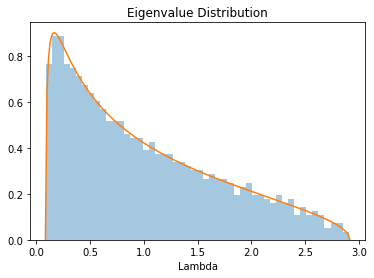

In [212]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

q=N/T
lambdas=np.linspace((1.-np.sqrt(q))**2,(1.+np.sqrt(q))**2,200)
P0s=P0(lambdas,q)
#Visualize the results
sns.distplot(lambdas_e,kde=False,norm_hist=True,bins=50)  # no Kernel Density Estimation
plt.xlabel('Lambda')
plt.title('Eigenvalue Distribution')
plt.plot(lambdas,P0s)
plt.show()

## Equity data : eigenvalue distribution
- Comparing equity data eigenvalues distribution with Marčenko Pastour Distribution for respective N and T

In [213]:
N=200
T=400  
t0=1000
t1=t0+T 
T_out=252  # a year
t1_out=t1+T_out
#taking a sample from our clean equity data

X_raw = dfclean.iloc[:T,:N]
X_raw_out = dfclean.iloc[T:t1_out,:N]
C_us = X_raw.corr() 

In [214]:
C_us    # check if the correlation was asset-wise

,A,ABT,ADM,AEE,AES,AFG,AFL,AIG,AJG,ALB,...,SNA,SNV,SO,SON,SRE,STT,SWK,SWN,SYK,SYY
A,1.000000,-0.141981,-0.039518,-0.157940,0.043395,0.022799,0.021862,0.051504,0.010520,0.092483,...,0.179462,0.101348,-0.211532,0.031261,-0.080493,0.123735,0.145917,0.064808,0.004292,-0.103495
ABT,-0.141981,1.000000,0.200682,0.241689,0.099301,0.073425,0.259328,0.323876,0.175322,0.071056,...,0.105977,0.238629,0.247708,0.109477,0.185074,0.230135,0.142650,-0.016492,0.193582,0.340968
ADM,-0.039518,0.200682,1.000000,0.220411,0.100820,0.132211,0.229861,0.275987,0.151219,0.152408,...,0.206729,0.332884,0.183633,0.163769,0.166679,0.299011,0.150550,0.102789,0.133828,0.240249
AEE,-0.157940,0.241689,0.220411,1.000000,0.289688,0.151286,0.273486,0.334936,0.236210,0.158428,...,0.181367,0.304536,0.712949,0.150695,0.502251,0.199790,0.162560,0.039584,0.094975,0.334064
AES,0.043395,0.099301,0.100820,0.289688,1.000000,0.071609,0.153819,0.205787,0.105104,0.113931,...,0.084534,0.188980,0.269312,0.049071,0.178603,0.173896,0.171701,0.085344,0.063037,0.062961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STT,0.123735,0.230135,0.299011,0.199790,0.173896,0.223199,0.378875,0.511472,0.344483,0.148481,...,0.318992,0.665827,0.219288,0.290229,0.138812,1.000000,0.360912,0.057568,0.239629,0.267154
SWK,0.145917,0.142650,0.150550,0.162560,0.171701,0.192807,0.247571,0.279550,0.177810,0.278673,...,0.487671,0.406803,0.099867,0.346556,0.096773,0.360912,1.000000,0.114408,0.160994,0.224692
SWN,0.064808,-0.016492,0.102789,0.039584,0.085344,0.089978,0.113837,0.063657,0.051151,0.103218,...,0.117927,0.049487,0.040080,0.082257,0.130534,0.057568,0.114408,1.000000,0.070056,-0.044392
SYK,0.004292,0.193582,0.133828,0.094975,0.063037,0.163964,0.152117,0.255809,0.247972,0.184621,...,0.178465,0.216572,0.166627,0.179683,0.048712,0.239629,0.160994,0.070056,1.000000,0.194753


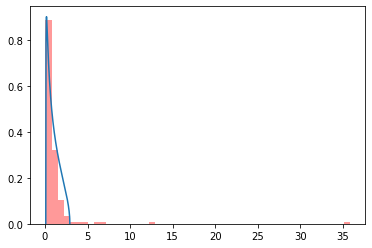

In [215]:
l_e, V_e = LA.eig(C_us)
N = C_us.shape[0]
q = N/T
lambda_plus = (1+np.sqrt(q))**2
lambdas=np.linspace((1.-np.sqrt(q))**2,(1.+np.sqrt(q))**2,200)
P0s=P0(lambdas,q)
sns.distplot(l_e,kde=False,norm_hist=True,bins=50,color = 'red') 
plt.plot(lambdas,P0s)

#we can observe that there are eigenvalues outside the random bulk


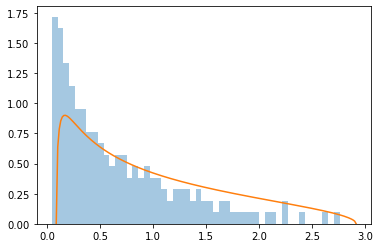

In [216]:
#visualizing better the eigenvalues inside random bulk

lambdas=np.linspace((1.-np.sqrt(q))**2,(1.+np.sqrt(q))**2,200)
P0s=P0(lambdas,q)
sns.distplot(l_e[l_e<lambda_plus],kde=False,norm_hist=True,bins=50) 
plt.plot(lambdas,P0s)


### Number of eigenvalues outside of the random bulk

In [217]:
print(f'Number of eigenvalues bigger lambda plus : {np.sum(l_e>lambda_plus)}')  # number of eigenvalue over lambda_plus
print( f'Percentage of eigenvalues outside random bulk : {np.sum(l_e>lambda_plus)*100/N} % ')

Number of eigenvalues bigger lambda plus : 7
Percentage of eigenvalues outside random bulk : 3.5 % 


# Trying to implement covariance estimation methods on a small sample of data first

In order to check that we get correct dimension of covariance matrices (assetwise and not daywise) we:
- select a small sample of in and out of sample data
- implement and check dimension of NLS method
- implement and check dimension of BAHC method
- implement and check dimension of Average Oracle method



In [49]:
#taking again a small sample of out data to try the methods
N=200
T=400 
t0=0 #starting time
t1=t0+T
T_out=150  # out of sample window, a year
t1_out=t1+T_out
X_raw = dfclean.iloc[:T,:N]
X_raw_out = dfclean.iloc[T:t1_out,:N]

In [50]:
#NLS method
X_centered = sklearn.preprocessing.StandardScaler(with_mean=True,
                           with_std=False).fit_transform(X_raw.values)  # column-wise!

#we are working with cov so it's important to set return_cov=True
Sigma_NLS=pyRMT.optimalShrinkage(X_centered,return_covariance= True)  
Sigma_NLS.shape   # check if NxN

(200, 200)

In [51]:
#BAHC method
Sigma_BAHC=bahc.filterCovariance(X_raw.T.values)
Sigma_BAHC.shape

(200, 200)

In [52]:
#Average Oracle method
l_AO = pd.read_csv('AO200.csv',index_col=0)
Sigma_AO = filterCovariance_AO(X_raw.cov(), np.diag(l_AO.values.reshape(200)))
Sigma_AO.shape

(200, 200)

## Portfolio optimisation

- Once we compute filter matrices for the small sample data, we implement an application with portfolio optimization. In particular we observe the impact of filtering on realized risk of the global minimum variance portfolio

Let us focus on Global Minimum Variance optimization where one only aims at minimizing the volatility of the portfolio. Denoting the investment weight into asset $i$ by $w_i$ and the covariance matrix by $\Sigma$, the problem can be written as
$$
w^*=\arg \max w^t \Sigma w\ \ \ \ \textrm{with }\sum_i w_i=1,
$$
where $w^t$ is the transpose of $w$.

Simple linear algebra (using Lagrange multipliers) yields 
$$
w^*=\frac{\Sigma^{-1}e}{e^t\Sigma^{-1}e},
$$
where $e$ is a vector full of 1: $w^*$ is the vector defined as the sum of the lines of $\Sigma^{-1}$ normalized by the sum of all the elements of $\Sigma^{-1}$.


In [12]:
#function to calculate weights of the global minimum variance portfolio
def weights_GVM(Sigma):
    '''
        input: Sigma: covariance matrix of dimension NxN
        output: vector of weights of dimension N
        '''
    
    Sigma_inv=LA.inv(Sigma)
    w_GVM=Sigma_inv.sum(axis=1)/Sigma_inv.sum()
    return w_GVM

In [219]:
#weights of Global minimum variance portfolio for each Covariance matrix
w = weights_GVM(X_raw.cov())
w_clip = weights_GVM(pyRMT.clipped(X_raw, return_covariance=True))
w_GBM_NLS=weights_GVM(Sigma_NLS)
w_GBM_BAHC=weights_GVM(Sigma_BAHC)
w_GBM_AO=weights_GVM(Sigma_AO)

In [220]:
#In Sample Variance
is_naive = w.T@(X_raw.cov())@w
is_clip = w_clip.T@(X_raw.cov())@w_clip
Is_risk_BAHC = w_GBM_BAHC@(X_raw.cov())@w_GBM_BAHC
Is_risk_NLS = w_GBM_NLS@(X_raw.cov())@w_GBM_NLS
Is_risk_AO = w_GBM_AO@(X_raw.cov())@w_GBM_AO
print(f'In sample risk for: \nNaive Sigma:{is_naive},\nEigenvalue clipping:{is_clip},\nBAHC:{Is_risk_BAHC},\nNLS:{Is_risk_NLS},\nAverage Oracle:{Is_risk_AO}')

In sample risk for: 
Naive Sigma:2.013793975263299e-05,
Eigenvalue clipping:4.516449797290784e-05,
BAHC:6.752762607818618e-05,
NLS:0.0001205007309590259,
Average Oracle:5.127176011270135e-05


### Out-of-sample portfolio volatility

Let us first define an out-of-sample interval. By definition, it will be $[t_1,t_1+T_{out}]$. For example $T_{out}=T$, or 2 weeks, or whatever.  Then the realized volatility is 
$$
\sigma_P^2 = w^t \Sigma w
$$
where $\Sigma$ is the realized, {unfiltered}, covariance matrix.

In [221]:
#out of sample risk
is_naive = w.T@(X_raw_out.cov())@w
is_clip = w_clip.T@(X_raw_out.cov())@w_clip
Is_risk_BAHC = w_GBM_BAHC@(X_raw_out.cov())@w_GBM_BAHC
Is_risk_NLS = w_GBM_NLS@(X_raw_out.cov())@w_GBM_NLS
Is_risk_AO = w_GBM_AO@(X_raw_out.cov())@w_GBM_AO
print(f'Out of sample risk for: \nNaive Sigma:{is_naive},\nEigenvalue clipping:{is_clip},\nBAHC:{Is_risk_BAHC},\nNLS:{Is_risk_NLS},\nAverage Oracle:{Is_risk_AO}')

Out of sample risk for: 
Naive Sigma:5.502146995777464e-05,
Eigenvalue clipping:5.032031634270802e-05,
BAHC:5.0768457077604904e-05,
NLS:9.565899410323277e-05,
Average Oracle:2.8584524470448153e-05


## We visualize the impact of Covariance cleaning for Mean Variance optimal portfolio
- Selecting subsample of data
- Constructing a range of optimal mean variance portfolios for different expected returns
- Comparing in sample risk vs realized out of sample risk for different expected returns 

For this comparison we use the portfolio that solves the following constrained optimization problem:

$$
\min_{w} \text{w}'\Sigma \text{w} \text{   s.t.   } \sum_i w_i g_i = G\\
$$

Which yields to:

$$
\textbf{w}_{MVP} = G \frac{\Sigma^{-1}\textbf{g}}{\textbf{g}'\Sigma^{-1}\textbf{g}}
$$

In [57]:
N=200
T=1000  

t0 = 1000
t1=t0+T
T_out=250  # a year
t1_out=t1+T_out

X_raw = dfclean.iloc[:T,:N]
X_raw_out = dfclean.iloc[T:t1_out,:N]


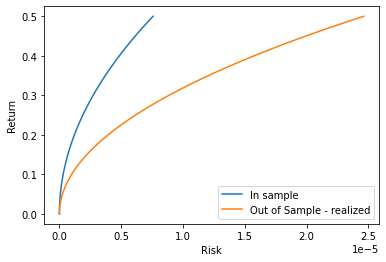

In [58]:
#predicted and realized return
g = (X_raw-1).mean(axis=0).values.reshape(N,1)
#insample risk
risk_in = lambda G : G**2 / (g.T@np.linalg.solve((X_raw-1).cov(),g))
Gvec=np.linspace(0,0.5,100)

risk_out_vec=[]
risk_in_vec=[]
Sigma = X_raw.cov()
for G in Gvec:
    g = (X_raw-1).mean(axis=0).values.reshape(N,1)
    w = G*((np.linalg.solve(X_raw.cov(),g)) / ((g.T@np.linalg.solve(X_raw.cov(),g))))
    #calculating realized return of w
    risk_in = (w).T @ X_raw.cov() @ (w)
    risk_out = (w).T @ X_raw_out.cov() @ (w)
    risk_out_vec.append(risk_out.values.flatten())
    risk_in_vec.append(risk_in.values.flatten())

plt.plot(risk_in_vec,Gvec,label='In sample')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.plot(risk_out_vec,Gvec,label='Out of Sample - realized')
plt.legend()
plt.show()

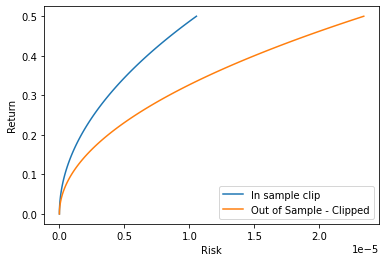

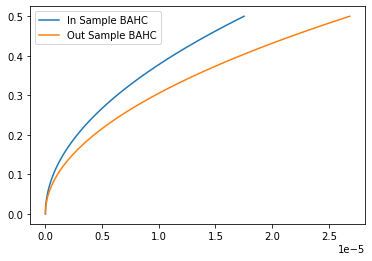

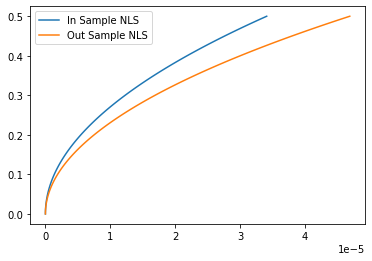

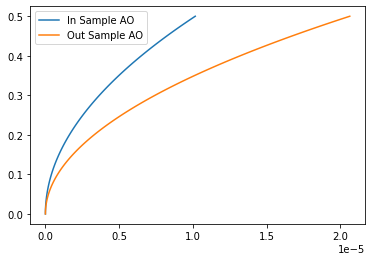

In [59]:
#predicted and realized return
g = (X_raw-1).mean(axis=0).values.reshape(N,1)
#insample risk
risk_in = lambda G : G**2 / (g.T@np.linalg.solve((X_raw-1).cov(),g))
Gvec=np.linspace(0,0.5,100)

Sigma = X_raw.cov()
Sigma_B = bahc.filterCovariance(X_raw.T.values)
Sigma_AO = filterCovariance_AO(Sigma, np.diag(l_AO.values.reshape(200)))
Sigma_NLS = pyRMT.optimalShrinkage(X_raw, return_covariance=True)
C_clip = pyRMT.clipped(X_raw, return_covariance=True)

risk_AO = []
risk_out_AO=[]
risk_out_clip=[]
risk_in_clip=[]
risk_in_B=[]
risk_out_BAHC=[]
risk_NLS = []
risk_out_NLS=[]
for G in Gvec:
    w = G*((np.linalg.solve(C_clip,g)) / ((g.T@np.linalg.solve(C_clip,g))))
    w_BAHC = G*((np.linalg.solve(Sigma_B,g)) / ((g.T@np.linalg.solve(Sigma_B,g))))
    w_AO = G*((np.linalg.solve(Sigma_AO,g)) / ((g.T@np.linalg.solve(Sigma_AO,g))))
    w_NLS = G*((np.linalg.solve(Sigma_NLS,g)) / ((g.T@np.linalg.solve(Sigma_NLS,g))))
    
    #calculating realized return of w
    risk_out_clip.append((w).T @ X_raw_out.cov() @ (w))
    risk_in_clip.append((w).T @ Sigma @ (w))
    risk_in_B.append((w_BAHC).T @ Sigma @ (w_BAHC))
    risk_out_BAHC.append((w_BAHC).T @ X_raw_out.cov() @ (w_BAHC))
    risk_AO.append((w_AO).T @ Sigma @ (w_AO))
    risk_out_AO.append((w_AO).T @ X_raw_out.cov() @ (w_AO))
    risk_NLS.append((w_NLS).T @ Sigma @ (w_NLS))
    risk_out_NLS.append((w_NLS).T @ X_raw_out.cov() @ (w_NLS))
    
plt.plot(np.array(risk_in_clip).flatten(),Gvec,label='In sample clip')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.plot(np.array(risk_out_clip).flatten(),Gvec,label='Out of Sample - Clipped')
plt.legend()
plt.show()

plt.plot(np.array(risk_in_B).flatten(),Gvec,label='In Sample BAHC')
plt.plot(np.array(risk_out_BAHC).flatten(),Gvec,label='Out Sample BAHC')
plt.legend()
plt.show()

plt.plot(np.array(risk_NLS).flatten(),Gvec,label='In Sample NLS')
plt.plot(np.array(risk_out_NLS).flatten(),Gvec,label='Out Sample NLS')
plt.legend()
plt.show()

plt.plot(np.array(risk_AO).flatten(),Gvec,label='In Sample AO')
plt.plot(np.array(risk_out_AO).flatten(),Gvec,label='Out Sample AO')
plt.legend()
plt.show()

## Rolling computations

In this section we implement the methods tried above in rolling windows of different lengths.
As a measure of goodness of prediction we use:
- out of sample risk for global minimum variance portfolio;
- out of sample return for mean variance optimum portfolio with G expected return 
- Frobenius Norm of the difference between in and out of sample covariance matrices

We make a comparison of the performances of the portfolio that solves the following constrained optimization problem:

$$
\min_{w} \text{w}'\Sigma \text{w} \\
$$


$$
\text{   s.t.   } \sum_i w_i g_i = G, \sum_i w_i = 1, |w_i| \leq 1, \text{for    } i = \{1,\ldots,N\}\\
$$

And if the solver is not able to find a solution we replace the weight vector with the normalized version of $\textbf{w}_{MVP}$, i.e. the Mean Variance portfolio but with rescaled weights such that they sum up to one.

The portfolios that we use for the comparison of the performances, are based on the previously described portfolio, but the only difference is the covariance matrix that we use in the construction. Indeed, we construct a portfolio for each of the following methods of covariance filtering:

- Eigenvalue clipping
- NLS
- Average Oracle
- BAHC

Finally, we compare the returns and the ratio between the returns and standard deviation (as metric to measure the performance) of each of these portfolios.

In [7]:
import cvxpy as cp

#function to calculate weigths of optimal mean variance portfolio without constraint and then imponing sum of w == 1

def weights(Sigma, g, G):
    '''
        input: Sigma: covariance matrix
               G: objective expected return
               g: vector of average returns 
        output: vector of weights of dimension N
        '''
    
    w = G*((np.linalg.solve(Sigma,g)) / ((g.T@np.linalg.solve(Sigma,g))))
    w = w/w.sum()
    return w

#function to calculate weigths of optimal mean variance portfolio given contraints
def wq(X_raw_in,Sigma,G,g,N):
    try:
        '''
        input: X_raw_in: data matrix T(days) rows, N columns(stock)
               Sigma: covariance matrix
               G: objective expected return
               g: vector of average returns 
               N: number of stocks
        output: vector of weights of dimension N
        '''
        w = cp.Variable(N)  # weights of the assets

        # Define the expected gain G 
        # Define the objective function
        objective = cp.Minimize(cp.quad_form(w, Sigma))

        # Define the constraints
        #we bound the weights of the portfolio
        constraints = [cp.sum(w) == 1, w@g == G, w<=1, w>= -1]


        # Form and solve the problem
        problem = cp.Problem(objective, constraints)
        problem.solve()
        w = w.value

    except:
        
        w = weights(Sigma, g, G)
        
        
    return w


In [8]:

def function(T, T_out, N, t, dfclean, l_AO, weights_GVM, filterCovariance_AO, bahc, wq, outputs):
    #
    R=dfclean
    np.random.seed(10)
    #selecting in sample matrix Rin and out of sample matrix Rout
    rin = R.iloc[t:t+T,:]
    rout = R.iloc[(t+T+1):(t+T+T_out),:]
    #randomly choosing N stocks (columns of Rin and Rout) between the ones without NaN values
    msk = np.random.choice(range(rin.shape[1]),size=N,replace=False)
    X_raw_in, X_raw_out = rin.iloc[:,msk],rout.iloc[:,msk]
    
    #calculating naive covariance matrix
    Sigma_in = X_raw_in.cov()
    Sigma_out = X_raw_out.cov()
    #calculating the covariance matrix for each of our four methods
    C_clip = pyRMT.clipped(X_raw_in, return_covariance=True)
    Sigma_AO = filterCovariance_AO(Sigma_in, np.diag(l_AO.values.reshape(N)))
    Sigma_NLS = pyRMT.optimalShrinkage(X_raw_in, return_covariance=True)
    Sigma_BAHC = bahc.filterCovariance(X_raw_in.T.values)

    #calculating weights of the Global Minimum Variance Portfolio
    w_GVM = weights_GVM(Sigma_in)
    w_GVM_clipped = weights_GVM(C_clip)
    w_GVM_NLS = weights_GVM(Sigma_NLS)
    w_GVM_BAHC = weights_GVM(Sigma_BAHC)
    w_GVM_AO = weights_GVM(Sigma_AO)
    
    #vector of expected returns for each asset
    g = (X_raw_in).mean(axis=0).values.reshape(N,1)

    #w for mean variance optimum portfolio for G = 3% and constraints
    w = wq(X_raw_in,Sigma_in,G,g,N)
    w_B = wq(X_raw_in,Sigma_BAHC,G,g,N)
    w_clip = wq(X_raw_in,C_clip,G,g,N)
    w_nls = wq(X_raw_in,Sigma_NLS,G,g,N)
    w_AO = wq(X_raw_in,Sigma_AO,G,g,N)
    
    
    #in sample risk
    outputs['risk_in_list'].append(w_GVM.T @ Sigma_in @ w_GVM)
    outputs['risk_in_cl'].append(w_GVM_clipped.T @ Sigma_in @ w_GVM_clipped)
    outputs['risk_in_NLS'].append(w_GVM_NLS.T @ Sigma_in @ w_GVM_NLS)
    outputs['risk_in_AO'].append(w_GVM_AO.T @ Sigma_in @ w_GVM_AO)
    outputs['risk_in_BAHC'].append(w_GVM_BAHC.T @ Sigma_in @ w_GVM_BAHC)
    
    #Frobenius norm of distance betweeen predicted matrix and realized one
    outputs['Norm_BAHC'].append(linalg.norm(Sigma_BAHC - Sigma_out, ord=None))
    outputs['Norm_AO'].append(linalg.norm(Sigma_AO - Sigma_out, ord=None))
    outputs['Norm_clip'].append(linalg.norm(C_clip - Sigma_out, ord=None))
    outputs['Norm_nls'].append(linalg.norm(Sigma_NLS - Sigma_out, ord=None))
    outputs['Norm_naive'].append(linalg.norm(Sigma_in - Sigma_out, ord=None))

    #out of sample (realized) risk
    outputs['risk_out_list'].append(w_GVM.T @ Sigma_out @ w_GVM)
    outputs['risk_out_cl'].append(w_GVM_clipped.T @ Sigma_out @ w_GVM_clipped)
    outputs['risk_out_NLS'].append(w_GVM_NLS.T @ Sigma_out @ w_GVM_NLS)
    outputs['risk_out_AO'].append(w_GVM_AO.T @ Sigma_out @ w_GVM_AO)
    outputs['risk_out_BAHC'].append(w_GVM_BAHC.T @ Sigma_out @ w_GVM_BAHC)

    # returns Constrained portfolio
    outputs['ret'].append(((X_raw_out+1).cumprod(axis=0)-1).iloc[-1,:] @ w ) 
    outputs['ret_BAHC'].append(((X_raw_out+1).cumprod(axis=0)-1).iloc[-1,:] @ w_B )
    outputs['ret_clip'].append(((X_raw_out+1).cumprod(axis=0)-1).iloc[-1,:] @ w_clip)
    outputs['ret_AO'].append(((X_raw_out+1).cumprod(axis=0)-1).iloc[-1,:] @ w_AO)
    outputs['ret_NLS'].append(((X_raw_out+1).cumprod(axis=0)-1).iloc[-1,:] @ w_nls)
 
    # realized return/(realized risk) of Constrained Portfolio
    outputs['SR'].append(outputs['ret'][-1] /np.sqrt(w.T @ Sigma_out @ w) )
    outputs['SR_BAHC'].append(outputs['ret_BAHC'][-1] / np.sqrt(w_B.T @ Sigma_out @ w_B) )
    outputs['SR_clip'].append(outputs['ret_clip'][-1] /np.sqrt((w_clip.T @ Sigma_out @ w_clip)))
    outputs['SR_AO'].append(outputs['ret_AO'][-1] /np.sqrt((w_AO.T @ Sigma_out @ w_AO) ))
    outputs['SR_NLS'].append(outputs['ret_NLS'][-1] /np.sqrt((w_nls.T @ Sigma_out @ w_nls)))
    
    
    return outputs

In [9]:
#Now we choose the hyperparameters
T=500 #length of rolling window
T_out=252 #length of out of sample rolling window to test results
N = 200 #number of stocks
l_AO = pd.read_csv('AO200.csv',index_col=0) 
G=0.03 # desired expected return for mean var portfolio

#lambda function depending only on t
fun = lambda t:function(T, T_out, N, t, dfclean, l_AO, weights_GVM, filterCovariance_AO, bahc, wq, outputs)

In [10]:
%%time
from multiprocessing.dummy import Pool
outputs={}

#empty lists to fill with desired outputs
outputs['risk_out_list'] = []
outputs['risk_in_list'] = []
outputs['risk_out_cl'] = []
outputs['risk_in_cl'] = []
outputs['risk_in_AO'] = []
outputs['risk_out_AO'] = []
outputs['risk_in_NLS'] = []
outputs['risk_out_NLS'] = []
outputs['risk_in_BAHC'] = []
outputs['risk_out_BAHC'] = []
outputs['Norm_BAHC']= []
outputs['Norm_AO'] = []
outputs['Norm_clip']= []
outputs['Norm_nls']= []
outputs['Norm_naive']= []


# returns Constrained portfolio
outputs['ret'] = []
outputs['ret_clip'] = []
outputs['ret_BAHC'] = []
outputs['ret_AO'] = []
outputs['ret_NLS'] = []


# Sharpe Ratio Constrained Portfolio

outputs['SR'] = []
outputs['SR_BAHC'] = []
outputs['SR_clip'] =[]
outputs['SR_AO'] = []
outputs['SR_NLS'] =[]



CPU times: total: 0 ns
Wall time: 4.77 ms


In [13]:
#we apply the rolling windows at time i for i as specified below 
#(we also have to consider here the length of out of sample rolling window)
for i in tqdm.tqdm(range(len(dfclean)-T-(T_out+1))):
    fun(i)


100%|████████████████████████████████████████████████████████████████████████████| 4845/4845 [1:40:03<00:00,  1.24s/it]


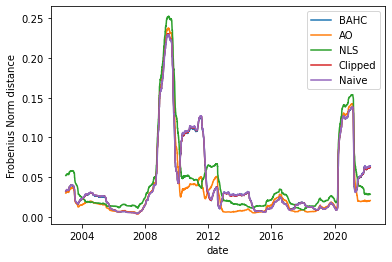

Mean value for: 
Naive Sigma:0.04360926096287986,
Eigenvalue clipping:0.04346410682727935,
BAHC:0.04347331890713356,
NLS:0.04475943985436721,
Average Oracle:0.034380933480043764


Each method outperform naive method in estimating out of sample cov matrix the following fraction of times: 
Eigenvalue clipping:0.567389060887513,
BAHC:0.5347781217750258,
NLS:0.3539731682146543,
Average Oracle:0.5529411764705883


In [14]:
#plot Frobenius Norm of the difference between realized covariance matrix and predicted one
a = dfclean.index[T+T_out+1:]
plt.plot(a,outputs['Norm_BAHC'],label='BAHC')
plt.plot(a,outputs['Norm_AO'],label='AO')
plt.plot(a,outputs['Norm_nls'],label='NLS')
plt.plot(a,outputs['Norm_clip'],label='Clipped')
plt.plot(a,outputs['Norm_naive'],label='Naive')
plt.legend()
plt.xlabel('date')
plt.ylabel('Frobenius Norm distance')
plt.show()
print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['Norm_naive']).mean()},\nEigenvalue clipping:{np.array(outputs['Norm_clip']).mean()},\nBAHC:{np.array(outputs['Norm_BAHC']).mean()},\nNLS:{np.array(outputs['Norm_nls']).mean()},\nAverage Oracle:{np.array(outputs['Norm_AO']).mean()}''')


print(f'''\n\nEach method outperform naive method in estimating out of sample cov matrix the following fraction of times: \nEigenvalue clipping:{(np.array(outputs['Norm_clip']).flatten()<np.array(outputs['Norm_naive'])).mean()},\nBAHC:{(np.array(outputs['Norm_BAHC']).flatten()<np.array(outputs['Norm_naive'])).mean()},\nNLS:{(np.array(outputs['Norm_naive']).flatten()>np.array(outputs['Norm_nls'])).mean()},\nAverage Oracle:{(np.array(outputs['Norm_naive']).flatten()>np.array(outputs['Norm_AO'])).mean()}''')


Mean value for: 
Eigenvalue clipping:3.1156436462796364,
BAHC:2.0769653024201373,
NLS:1.755650099782429,
Average Oracle:2.859344859335465,
Naive:6.963102314673914


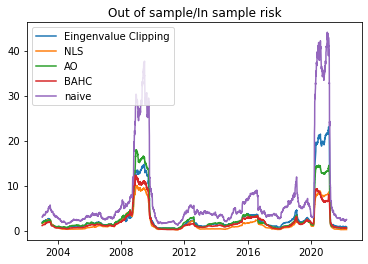

In [15]:
#ratio between out of sample and in sample risk for each method
plt.plot(a,np.array(outputs['risk_out_cl']).flatten()/np.array(outputs['risk_in_cl']).flatten(), label = 'Eingenvalue Clipping')
plt.plot(a,np.array(outputs['risk_out_NLS']).flatten()/np.array(outputs['risk_in_NLS']).flatten(), label = 'NLS')
plt.plot(a,np.array(outputs['risk_out_AO']).flatten()/np.array(outputs['risk_in_AO']).flatten(), label = 'AO')
plt.plot(a,np.array(outputs['risk_out_BAHC']).flatten()/np.array(outputs['risk_in_BAHC']).flatten(), label = 'BAHC')
plt.plot(a,np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_in_list']).flatten(), label = 'naive')


plt.title('Out of sample/In sample risk')
plt.legend()

print(f'''Mean value for: \nEigenvalue clipping:{(np.array(outputs['risk_out_cl']).flatten()/np.array(outputs['risk_in_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_BAHC']).flatten()/np.array(outputs['risk_in_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_NLS']).flatten()/np.array(outputs['risk_in_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_AO']).flatten()/np.array(outputs['risk_in_AO'])).mean()},\nNaive:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_in_list'])).mean()}''')



Mean value for: 
Eigenvalue clipping:1.2134338350446143,
BAHC:1.1742351388573131,
NLS:0.6588287180647139,
Average Oracle:1.419558027549489


Each method outperform naive method in estimate out of sample risk the following fraction of times: 
Eigenvalue clipping:0.9182662538699691,
BAHC:0.6513931888544892,
NLS:0.13890608875128999,
Average Oracle:0.9723426212590299


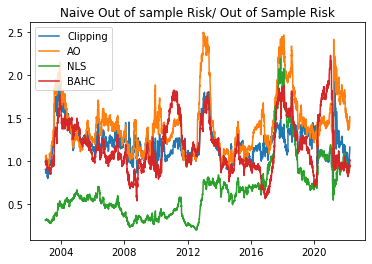

In [16]:
# ratio between out of naive portfolio out of sample naive risk and i-th method out of sample risk
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_cl']).flatten(),label='Clipping')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_AO']).flatten(),label='AO')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_NLS']).flatten(),label='NLS')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_BAHC']).flatten(),label='BAHC')
plt.title('Naive Out of sample Risk/ Out of Sample Risk')
plt.legend()
print(f'''Mean value for: \nEigenvalue clipping:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_AO'])).mean()}''')

print(f'''\n\nEach method outperform naive method in estimate out of sample risk the following fraction of times: \nEigenvalue clipping:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_AO'])).mean()}''')


Mean value for: 
Naive Sigma:0.19678757283053938,
Eigenvalue clipping:0.11426266497819998,
BAHC:0.2242476286458562,
NLS:[-0.5779145],
Average Oracle:0.17032884569121776


Each method outperform naive method in return terms the following percentage of times: 
Eigenvalue clipping:0.5178534571723427,
BAHC:0.5376676986584107,
NLS:0.44891640866873067,
Average Oracle:0.5170278637770898


C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\Utente\AppData\Local\Temp\ipykernel_25432\2288993136.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['ret']).mean()},\nEigenvalue clipping:{np.array(outputs['ret_clip']).mean()},\nBAHC:{np.array(outputs['ret_BAHC']).mean()},\nNLS:{np.array(outputs['ret_NLS']).mean()},\nAverage Oracle:{np.array(outputs['ret_AO']).mean()}''')
C:\Users\Utente\A

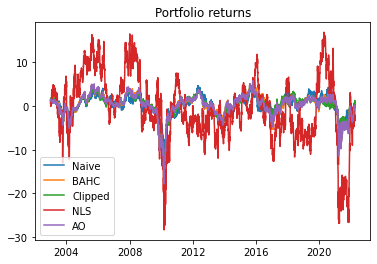

In [17]:
#plot realized returns for our mean variance optimum portfolios
plt.plot(a,outputs['ret'],label = 'Naive')
plt.plot(a,outputs['ret_BAHC'],label='BAHC')
plt.plot(a,outputs['ret_clip'],label = 'Clipped')
plt.plot(a,outputs['ret_NLS'], label = 'NLS')
plt.plot(a,outputs['ret_AO'],label='AO')
plt.title('Portfolio returns')
plt.legend()
plt.show

print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['ret']).mean()},\nEigenvalue clipping:{np.array(outputs['ret_clip']).mean()},\nBAHC:{np.array(outputs['ret_BAHC']).mean()},\nNLS:{np.array(outputs['ret_NLS']).mean()},\nAverage Oracle:{np.array(outputs['ret_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in return terms the following percentage of times: \nEigenvalue clipping:{(np.array(outputs['ret_clip']).flatten()>np.array(outputs['ret'])).mean()},\nBAHC:{(np.array(outputs['ret_BAHC']).flatten()>np.array(outputs['ret'])).mean()},\nNLS:{(np.array(outputs['ret']).flatten()<np.array(outputs['ret_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['ret_AO']).flatten()>np.array(outputs['ret'])).mean()}''')



In [19]:
SR_list = []
for i in range(len(outputs['SR_NLS'])):
    if type(outputs['SR_NLS'][i])==pd.core.frame.DataFrame:
        SR_list.append(np.float(outputs['SR_NLS'][i].values))
    else:
        SR_list.append(outputs['SR_NLS'][i])

C:\Users\Utente\AppData\Local\Temp\ipykernel_25432\675345006.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SR_list.append(np.float(outputs['SR_NLS'][i].values))


Mean value for: 
Naive Sigma:2.539696893644901,
Eigenvalue clipping:-0.766960572637737,
Average Oracle:4.070560937900439


Each method outperform naive method in SR the following percentage of times: 
Eigenvalue clipping:0.5351909184726522,
BAHC:0.5622291021671827,
NLS:0.43323013415892675,
Average Oracle:0.5285861713106295


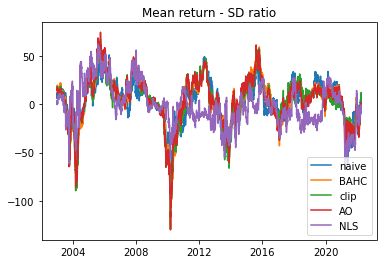

In [21]:
#plotting time series of Realized returns/(out ofsample risk) for each method (we call it SR but we are disregarding the riskfree value)
plt.plot(a,outputs['SR'],label='naive')
plt.plot(a,outputs['SR_BAHC'],label='BAHC')
plt.plot(a,outputs['SR_clip'],label='clip')
plt.plot(a,outputs['SR_AO'],label='AO')
plt.plot(a,SR_list,label='NLS')
plt.legend()
plt.title('Mean return - SD ratio')

print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['SR']).mean()},\nEigenvalue clipping:{np.array(SR_list).mean()},\nAverage Oracle:{np.array(outputs['SR_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in SR the following percentage of times: \nEigenvalue clipping:{(np.array(outputs['SR_clip']).flatten()>np.array(outputs['SR'])).mean()},\nBAHC:{(np.array(outputs['SR_BAHC']).flatten()>np.array(outputs['SR'])).mean()},\nNLS:{(np.array(outputs['SR']).flatten()<np.array(SR_list)).mean()},\nAverage Oracle:{(np.array(outputs['SR_AO']).flatten()>np.array(outputs['SR'])).mean()}''')


## Reducing size of Rolling window to 1 year of observations
We try this variant to observe how results change

In [ ]:
T=252
T_out=252
N = 200
l_AO = pd.read_csv('AO200.csv',index_col=0)
G=0.03
fun = lambda t:function(T, T_out, N, t, dfclean, l_AO, weights_GVM, filterCovariance_AO, bahc, wq, outputs)

In [ ]:
%%time
from multiprocessing.dummy import Pool
outputs={}

outputs['risk_out_list'] = []
outputs['risk_in_list'] = []
outputs['risk_out_cl'] = []
outputs['risk_in_cl'] = []
outputs['risk_in_AO'] = []
outputs['risk_out_AO'] = []
outputs['risk_in_NLS'] = []
outputs['risk_out_NLS'] = []
outputs['risk_in_BAHC'] = []
outputs['risk_out_BAHC'] = []
outputs['Norm_BAHC']= []
outputs['Norm_AO'] = []
outputs['Norm_clip']= []
outputs['Norm_nls']= []
outputs['Norm_naive']= []


# returns Constrained portfolio
outputs['ret'] = []
outputs['ret_clip'] = []
outputs['ret_BAHC'] = []
outputs['ret_AO'] = []
outputs['ret_NLS'] = []

# returns Unconstrained portfolio
outputs['ret_un'] = []
outputs['ret_clip_un'] = []
outputs['ret_BAHC_un'] = []
outputs['ret_AO_un'] = []
outputs['ret_NLS_un'] = []

# Sharpe Ratio Constrained Portfolio

outputs['SR'] = []
outputs['SR_BAHC'] = []
outputs['SR_clip'] =[]
outputs['SR_AO'] = []
outputs['SR_NLS'] =[]

# Sharpe Ratio Unconstrained Portfolio

outputs['SR_un'] = []
outputs['SR_BAHC_un'] = []
outputs['SR_clip_un'] =[]
outputs['SR_AO_un'] = []
outputs['SR_NLS_un'] =[]





In [ ]:
for i in tqdm.tqdm(range(len(dfclean)-T-(T_out+1))):
    fun(i)


In [ ]:
#plot Frobenius Norm of the difference between realized covariance matrix and predicted one
a = dfclean.index[T+T_out+1:]

plt.plot(a,outputs['Norm_BAHC'],label='BAHC')
plt.plot(a,outputs['Norm_AO'],label='AO')
plt.plot(a,outputs['Norm_nls'],label='NLS')
plt.plot(a,outputs['Norm_clip'],label='Clipped')
plt.plot(a,outputs['Norm_naive'],label='Naive')
plt.legend()
plt.xlabel('date')
plt.ylabel('Frobenius Norm distance')
plt.show()
print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['Norm_naive']).mean()},\nEigenvalue clipping:{np.array(outputs['Norm_clip']).mean()},\nBAHC:{np.array(outputs['Norm_BAHC']).mean()},\nNLS:{np.array(outputs['Norm_nls']).mean()},\nAverage Oracle:{np.array(outputs['Norm_AO']).mean()}''')


print(f'''\n\nEach method outperform naive method in estimating out of sample cov matrix the following fraction of times: \nEigenvalue clipping:{(np.array(outputs['Norm_clip']).flatten()<np.array(outputs['Norm_naive'])).mean()},\nBAHC:{(np.array(outputs['Norm_BAHC']).flatten()<np.array(outputs['Norm_naive'])).mean()},\nNLS:{(np.array(outputs['Norm_naive']).flatten()>np.array(outputs['Norm_nls'])).mean()},\nAverage Oracle:{(np.array(outputs['Norm_naive']).flatten()>np.array(outputs['Norm_AO'])).mean()}''')

In [ ]:
#ratio between out of sample and in sample risk
plt.plot(a,np.array(outputs['risk_out_cl']).flatten()/np.array(outputs['risk_in_cl']).flatten(), label = 'Eingenvalue Clipping')
plt.plot(a,np.array(outputs['risk_out_NLS']).flatten()/np.array(outputs['risk_in_NLS']).flatten(), label = 'NLS')
plt.plot(a,np.array(outputs['risk_out_AO']).flatten()/np.array(outputs['risk_in_AO']).flatten(), label = 'AO')
plt.plot(a,np.array(outputs['risk_out_BAHC']).flatten()/np.array(outputs['risk_in_BAHC']).flatten(), label = 'BAHC')
plt.plot(a,np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_in_list']).flatten(), label = 'naive')

plt.title('Out of sample/In sample risk')
plt.legend()
print(f'''Mean value for: \nEigenvalue clipping:{(np.array(outputs['risk_out_cl']).flatten()/np.array(outputs['risk_in_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_BAHC']).flatten()/np.array(outputs['risk_in_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_NLS']).flatten()/np.array(outputs['risk_in_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_AO']).flatten()/np.array(outputs['risk_in_AO'])).mean()},\nNaive:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_in_list'])).mean()}''')

In [ ]:
# ratio between out of naive portfolio out of sample risk and i-th method out of sample risk
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_cl']).flatten(),label='Clipping',)
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_AO']).flatten(),label='AO')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_NLS']).flatten(),label='NLS')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_BAHC']).flatten(),label='BAHC')
plt.title('Naive Out of sample Risk/ Out of Sample Risk')
plt.legend()
print(f'''Mean value for: \nEigenvalue clipping:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_AO'])).mean()}''')


print(f'''\n\nEach method outperform naive method in estimate out of sample risk the following fraction of times: \nEigenvalue clipping:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_AO'])).mean()}''')

In [ ]:
plt.plot(a,outputs['ret'],label = 'Naive')
plt.plot(a,outputs['ret_BAHC'],label='BAHC')
plt.plot(a,outputs['ret_clip'],label = 'Clipped')
plt.plot(a,outputs['ret_NLS'], label = 'NLS')
plt.plot(a,outputs['ret_AO'],label='AO')
plt.title('Portfolio returns')
plt.legend()
plt.show

print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['ret']).mean()},\nEigenvalue clipping:{np.array(outputs['ret_clip']).mean()},\nBAHC:{np.array(outputs['ret_BAHC']).mean()},\nNLS:{np.array(outputs['ret_NLS']).mean()},\nAverage Oracle:{np.array(outputs['ret_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in return terms the following percentage of times: \nEigenvalue clipping:{(np.array(outputs['ret_clip']).flatten()>np.array(outputs['ret'])).mean()},\nBAHC:{(np.array(outputs['ret_BAHC']).flatten()>np.array(outputs['ret'])).mean()},\nNLS:{(np.array(outputs['ret']).flatten()<np.array(outputs['ret_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['ret_AO']).flatten()>np.array(outputs['ret'])).mean()}''')


In [ ]:
# Here we add a correction to the list which contains the Mean return - SD ratio which enables us to plot it correctly
SR_list = []
for i in range(len(outputs['SR_NLS'])):
    if type(outputs['SR_NLS'][i])==pd.core.frame.DataFrame:
        SR_list.append(np.float(outputs['SR_NLS'][i].values))
    else:
        SR_list.append(outputs['SR_NLS'][i])

In [ ]:
plt.plot(a,outputs['SR'],label='naive')
plt.plot(a,outputs['SR_BAHC'],label='BAHC')
plt.plot(a,outputs['SR_clip'],label='clip')
plt.plot(a,outputs['SR_AO'],label='AO')
plt.plot(a,SR_list,label='NLS')
plt.legend()
plt.title('Mean return - SD ratio')

print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['SR']).mean()},\nEigenvalue clipping:{np.array(outputs['SR_clip']).mean()},\nBAHC:{np.array(outputs['SR_BAHC']).mean()},\nNLS:{np.array(SR_list).mean()},\nAverage Oracle:{np.array(outputs['SR_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in SR the following percentage of times: \nEigenvalue clipping:{(np.array(outputs['SR_clip']).flatten()>np.array(outputs['SR'])).mean()},\nBAHC:{(np.array(outputs['SR_BAHC']).flatten()>np.array(outputs['SR'])).mean()},\nNLS:{(np.array(outputs['SR']).flatten()<np.array(SR_list)).mean()},\nAverage Oracle:{(np.array(outputs['SR_AO']).flatten()>np.array(outputs['SR'])).mean()}''')

## Reducing number of stock of the portfolio to 100

In [22]:
#as before we set the desired function values
T = 252
T_out = 125
N = 100
l_AO = pd.read_csv('AO100.csv',index_col=0)
G = 0.03

fun = lambda t:function(T, T_out, N, t, dfclean, l_AO, weights_GVM, filterCovariance_AO, bahc,wq,outputs)

outputs={}
outputs['risk_out_list'] = []
outputs['risk_in_list'] = []
outputs['risk_out_cl'] = []
outputs['risk_in_cl'] = []
outputs['risk_in_AO'] = []
outputs['risk_out_AO'] = []
outputs['risk_in_NLS'] = []
outputs['risk_out_NLS'] = []
outputs['risk_in_BAHC'] = []
outputs['risk_out_BAHC'] = []
outputs['Norm_BAHC']= []
outputs['Norm_AO'] = []
outputs['Norm_clip']= []
outputs['Norm_nls']= []
outputs['Norm_naive']= []


# returns Constrained portfolio
outputs['ret'] = []
outputs['ret_clip'] = []
outputs['ret_BAHC'] = []
outputs['ret_AO'] = []
outputs['ret_NLS'] = []

# returns Unconstrained portfolio
outputs['ret_un'] = []
outputs['ret_clip_un'] = []
outputs['ret_BAHC_un'] = []
outputs['ret_AO_un'] = []
outputs['ret_NLS_un'] = []

# Sharpe Ratio Constrained Portfolio

outputs['SR'] = []
outputs['SR_BAHC'] = []
outputs['SR_clip'] =[]
outputs['SR_AO'] = []
outputs['SR_NLS'] =[]

# Sharpe Ratio Unconstrained Portfolio

outputs['SR_un'] = []
outputs['SR_BAHC_un'] = []
outputs['SR_clip_un'] =[]
outputs['SR_AO_un'] = []
outputs['SR_NLS_un'] =[]

#Pool(6).map((fun),range(len(dfclean)-T-(T_out+1)))
for i in tqdm.tqdm(range(len(dfclean)-T-(T_out+1))):
    fun(i)


100%|██████████████████████████████████████████████████████████████████████████████| 5220/5220 [28:58<00:00,  3.00it/s]


Mean value for: 
Naive Sigma:0.021557212937348663,
Eigenvalue clipping:0.021364438858109496,
BAHC:0.021311074365125596,
NLS:0.022761755019483427,
Average Oracle:0.017542044142501347


Each method outperform naive method in estimating out of sample cov matrix the following fraction of times: 
Eigenvalue clipping:0.6434865900383142,
BAHC:0.6496168582375479,
NLS:0.2454022988505747,
Average Oracle:0.5670498084291188


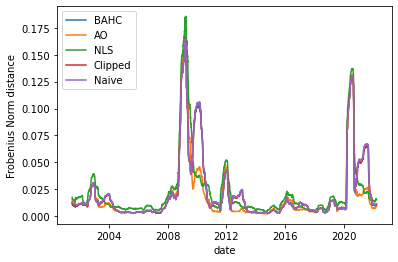

In [23]:
#plot Frobenius Norm of the difference between realized covariance matrix and predicted one
a = dfclean.index[T+T_out+1:]
plt.plot(a,outputs['Norm_BAHC'],label='BAHC')
plt.plot(a,outputs['Norm_AO'],label='AO')
plt.plot(a,outputs['Norm_nls'],label='NLS')
plt.plot(a,outputs['Norm_clip'],label='Clipped')
plt.plot(a,outputs['Norm_naive'],label='Naive')
plt.legend()
plt.xlabel('date')
plt.ylabel('Frobenius Norm distance')
print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['Norm_naive']).mean()},\nEigenvalue clipping:{np.array(outputs['Norm_clip']).mean()},\nBAHC:{np.array(outputs['Norm_BAHC']).mean()},\nNLS:{np.array(outputs['Norm_nls']).mean()},\nAverage Oracle:{np.array(outputs['Norm_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in estimating out of sample cov matrix the following fraction of times: \nEigenvalue clipping:{(np.array(outputs['Norm_clip']).flatten()<np.array(outputs['Norm_naive'])).mean()},\nBAHC:{(np.array(outputs['Norm_BAHC']).flatten()<np.array(outputs['Norm_naive'])).mean()},\nNLS:{(np.array(outputs['Norm_naive']).flatten()>np.array(outputs['Norm_nls'])).mean()},\nAverage Oracle:{(np.array(outputs['Norm_naive']).flatten()>np.array(outputs['Norm_AO'])).mean()}''')


Mean value for: 
Eigenvalue clipping:2.833386684718084,
BAHC:2.1337267915271507,
NLS:1.5214086600416954,
Average Oracle:2.348915837482875,
Naive:5.083794306242309


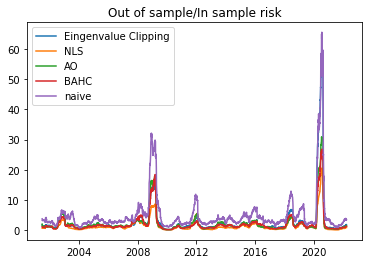

In [24]:
#ratio between out of sample and in sample risk
plt.plot(a,np.array(outputs['risk_out_cl']).flatten()/np.array(outputs['risk_in_cl']).flatten(), label = 'Eingenvalue Clipping')
plt.plot(a,np.array(outputs['risk_out_NLS']).flatten()/np.array(outputs['risk_in_NLS']).flatten(), label = 'NLS')
plt.plot(a,np.array(outputs['risk_out_AO']).flatten()/np.array(outputs['risk_in_AO']).flatten(), label = 'AO')
plt.plot(a,np.array(outputs['risk_out_BAHC']).flatten()/np.array(outputs['risk_in_BAHC']).flatten(), label = 'BAHC')
plt.plot(a,np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_in_list']).flatten(), label = 'naive')

plt.title('Out of sample/In sample risk')
plt.legend()
print(f'''Mean value for: \nEigenvalue clipping:{(np.array(outputs['risk_out_cl']).flatten()/np.array(outputs['risk_in_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_BAHC']).flatten()/np.array(outputs['risk_in_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_NLS']).flatten()/np.array(outputs['risk_in_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_AO']).flatten()/np.array(outputs['risk_in_AO'])).mean()},\nNaive:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_in_list'])).mean()}''')


Mean value for: 
Eigenvalue clipping:1.2212147211182223,
BAHC:1.2161207906601723,
NLS:0.7312041981935729,
Average Oracle:1.4431769193392407


Each method outperform naive method in estimate out of sample risk the following fraction of times: 
Eigenvalue clipping:0.8293103448275863,
BAHC:0.7886973180076629,
NLS:0.1582375478927203,
Average Oracle:0.9082375478927203


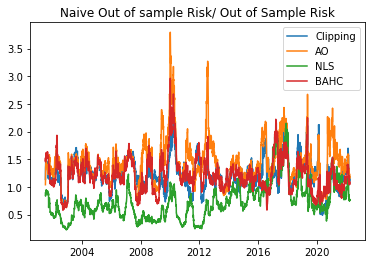

In [25]:
# ratio between out of naive portfolio out of sample risk and i-th method out of sample risk
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_cl']).flatten(),label='Clipping')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_AO']).flatten(),label='AO')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_NLS']).flatten(),label='NLS')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_BAHC']).flatten(),label='BAHC')

plt.title('Naive Out of sample Risk/ Out of Sample Risk')
plt.legend()
print(f'''Mean value for: \nEigenvalue clipping:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_AO'])).mean()}''')

print(f'''\n\nEach method outperform naive method in estimate out of sample risk the following fraction of times: \nEigenvalue clipping:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_AO'])).mean()}''')


Mean value for: 
Naive Sigma:0.048957889399249305,
Eigenvalue clipping:0.04933160291086855,
BAHC:0.014818792856816893,
NLS:-0.1455570292491464,
Average Oracle:0.022414041156985896


Each method outperform naive method in return terms the following percentage of times: 
Eigenvalue clipping:0.4982758620689655,
BAHC:0.45306513409961685,
NLS:0.49770114942528737,
Average Oracle:0.46302681992337164


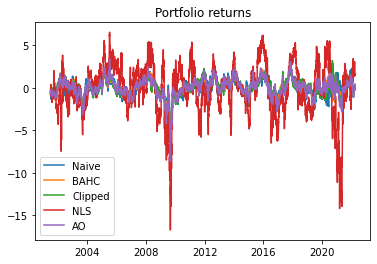

In [26]:
plt.plot(a,outputs['ret'],label = 'Naive')
plt.plot(a,outputs['ret_BAHC'],label='BAHC')
plt.plot(a,outputs['ret_clip'],label = 'Clipped')
plt.plot(a,outputs['ret_NLS'], label = 'NLS')
plt.plot(a,outputs['ret_AO'],label='AO')
plt.title('Portfolio returns')
plt.legend()
plt.show

print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['ret']).mean()},\nEigenvalue clipping:{np.array(outputs['ret_clip']).mean()},\nBAHC:{np.array(outputs['ret_BAHC']).mean()},\nNLS:{np.array(outputs['ret_NLS']).mean()},\nAverage Oracle:{np.array(outputs['ret_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in return terms the following percentage of times: \nEigenvalue clipping:{(np.array(outputs['ret_clip']).flatten()>np.array(outputs['ret'])).mean()},\nBAHC:{(np.array(outputs['ret_BAHC']).flatten()>np.array(outputs['ret'])).mean()},\nNLS:{(np.array(outputs['ret']).flatten()<np.array(outputs['ret_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['ret_AO']).flatten()>np.array(outputs['ret'])).mean()}''')


Mean value for: 
Naive Sigma:0.6255788652806491,
Eigenvalue clipping:0.46395242762773964,
BAHC:0.09987695300352745,
NLS:0.46468486326027153,
Average Oracle:0.42915987073721623


Each method outperform naive method in SR the following percentage of times: 
Eigenvalue clipping:0.5024904214559387,
BAHC:0.46704980842911875,
NLS:0.49693486590038316,
Average Oracle:0.47758620689655173


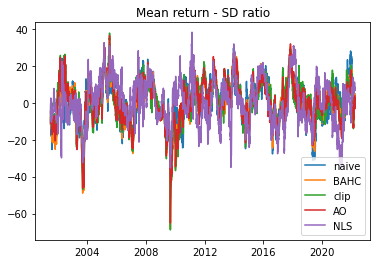

In [28]:
plt.plot(a,outputs['SR'],label='naive')
plt.plot(a,outputs['SR_BAHC'],label='BAHC')
plt.plot(a,outputs['SR_clip'],label='clip')
plt.plot(a,outputs['SR_AO'],label='AO')
plt.plot(a,outputs['SR_NLS'],label='NLS')
plt.legend()
plt.title('Mean return - SD ratio')

print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['SR']).mean()},\nEigenvalue clipping:{np.array(outputs['SR_clip']).mean()},\nBAHC:{np.array(outputs['SR_BAHC']).mean()},\nNLS:{np.array(outputs['SR_NLS']).mean()},\nAverage Oracle:{np.array(outputs['SR_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in SR the following percentage of times: \nEigenvalue clipping:{(np.array(outputs['SR_clip']).flatten()>np.array(outputs['SR'])).mean()},\nBAHC:{(np.array(outputs['SR_BAHC']).flatten()>np.array(outputs['SR'])).mean()},\nNLS:{(np.array(outputs['SR']).flatten()<np.array(outputs['SR_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['SR_AO']).flatten()>np.array(outputs['SR'])).mean()}''')


## Rolling window with N=100 stocks and T=500

In [333]:
#as before, we set our function values
T = 500
T_out = 252
N = 100
l_AO = pd.read_csv('AO100.csv',index_col=0)
G = 0.03

fun = lambda t:function(T, T_out, N, t, dfclean, l_AO, weights_GVM, filterCovariance_AO, bahc,wq,outputs)

outputs={}
outputs['risk_out_list'] = []
outputs['risk_in_list'] = []
outputs['risk_out_cl'] = []
outputs['risk_in_cl'] = []
outputs['risk_in_AO'] = []
outputs['risk_out_AO'] = []
outputs['risk_in_NLS'] = []
outputs['risk_out_NLS'] = []
outputs['risk_in_BAHC'] = []
outputs['risk_out_BAHC'] = []
outputs['Norm_BAHC']= []
outputs['Norm_AO'] = []
outputs['Norm_clip']= []
outputs['Norm_nls']= []
outputs['Norm_naive']= []


# returns Constrained portfolio
outputs['ret'] = []
outputs['ret_clip'] = []
outputs['ret_BAHC'] = []
outputs['ret_AO'] = []
outputs['ret_NLS'] = []

# returns Unconstrained portfolio
outputs['ret_un'] = []
outputs['ret_clip_un'] = []
outputs['ret_BAHC_un'] = []
outputs['ret_AO_un'] = []
outputs['ret_NLS_un'] = []

# Sharpe Ratio Constrained Portfolio

outputs['SR'] = []
outputs['SR_BAHC'] = []
outputs['SR_clip'] =[]
outputs['SR_AO'] = []
outputs['SR_NLS'] =[]

# Sharpe Ratio Unconstrained Portfolio

outputs['SR_un'] = []
outputs['SR_BAHC_un'] = []
outputs['SR_clip_un'] =[]
outputs['SR_AO_un'] = []
outputs['SR_NLS_un'] =[]

#Pool(6).map((fun),range(len(dfclean)-T-(T_out+1)))
for i in tqdm.tqdm(range(len(dfclean)-T-(T_out+1))):
    fun(i)


100%|██████████████████████████████████████████████████████████████████████████████| 4845/4845 [32:21<00:00,  2.50it/s]


Mean value for: 
Naive Sigma:0.021692616958049336,
Eigenvalue clipping:0.02161321686153422,
BAHC:0.02158144403687919,
NLS:0.02250786209582814,
Average Oracle:0.01751472236343633


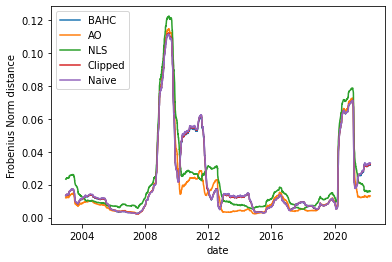

In [334]:
#plot Frobenius Norm of the difference between realized covariance matrix and predicted one
a = dfclean.index[T+T_out+1:]
plt.plot(a,outputs['Norm_BAHC'],label='BAHC')
plt.plot(a,outputs['Norm_AO'],label='AO')
plt.plot(a,outputs['Norm_nls'],label='NLS')
plt.plot(a,outputs['Norm_clip'],label='Clipped')
plt.plot(a,outputs['Norm_naive'],label='Naive')
plt.legend()
plt.xlabel('date')
plt.ylabel('Frobenius Norm distance')
print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['Norm_naive']).mean()},\nEigenvalue clipping:{np.array(outputs['Norm_clip']).mean()},\nBAHC:{np.array(outputs['Norm_BAHC']).mean()},\nNLS:{np.array(outputs['Norm_nls']).mean()},\nAverage Oracle:{np.array(outputs['Norm_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in estimating out of sample cov matrix the following fraction of times: \nEigenvalue clipping:{(np.array(outputs['Norm_clip']).flatten()<np.array(outputs['Norm_naive'])).mean()},\nBAHC:{(np.array(outputs['Norm_BAHC']).flatten()<np.array(outputs['Norm_naive'])).mean()},\nNLS:{(np.array(outputs['Norm_naive']).flatten()>np.array(outputs['Norm_nls'])).mean()},\nAverage Oracle:{(np.array(outputs['Norm_naive']).flatten()>np.array(outputs['Norm_AO'])).mean()}''')


Mean value for: 
Eigenvalue clipping:2.8601896672423854,
BAHC:2.1859927677774915,
NLS:1.7647512876443268,
Average Oracle:2.3484412909780974,
Naive:3.487956472967666


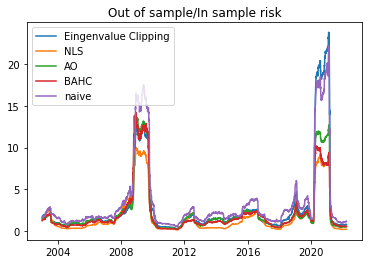

In [335]:
#ratio between out of sample and in sample risk
plt.plot(a,np.array(outputs['risk_out_cl']).flatten()/np.array(outputs['risk_in_cl']).flatten(), label = 'Eingenvalue Clipping')
plt.plot(a,np.array(outputs['risk_out_NLS']).flatten()/np.array(outputs['risk_in_NLS']).flatten(), label = 'NLS')
plt.plot(a,np.array(outputs['risk_out_AO']).flatten()/np.array(outputs['risk_in_AO']).flatten(), label = 'AO')
plt.plot(a,np.array(outputs['risk_out_BAHC']).flatten()/np.array(outputs['risk_in_BAHC']).flatten(), label = 'BAHC')
plt.plot(a,np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_in_list']).flatten(), label = 'naive')

plt.title('Out of sample/In sample risk')
plt.legend()
print(f'''Mean value for: \nEigenvalue clipping:{(np.array(outputs['risk_out_cl']).flatten()/np.array(outputs['risk_in_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_BAHC']).flatten()/np.array(outputs['risk_in_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_NLS']).flatten()/np.array(outputs['risk_in_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_AO']).flatten()/np.array(outputs['risk_in_AO'])).mean()},\nNaive:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_in_list'])).mean()}''')


Mean value for: 
Eigenvalue clipping:1.004516317770437,
BAHC:0.97939203986807,
NLS:0.6111993135580901,
Average Oracle:1.1430261320267763


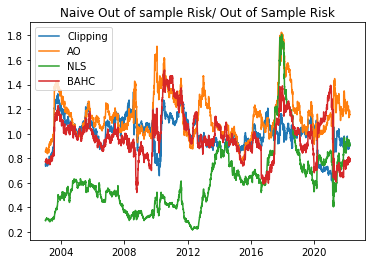

In [336]:
# ratio between out of naive portfolio out of sample risk and i-th method out of sample risk
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_cl']).flatten(),label='Clipping')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_AO']).flatten(),label='AO')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_NLS']).flatten(),label='NLS')
plt.plot(a,np.array(outputs['risk_out_list'])/np.array(outputs['risk_out_BAHC']).flatten(),label='BAHC')
plt.title('Naive Out of sample Risk/ Out of Sample Risk')
plt.legend()
print(f'''Mean value for: \nEigenvalue clipping:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_list']).flatten()/np.array(outputs['risk_out_AO'])).mean()}''')

print(f'''\n\nEach method outperform naive method in estimate out of sample risk the following fraction of times: \nEigenvalue clipping:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_cl'])).mean()},\nBAHC:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_BAHC'])).mean()},\nNLS:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['risk_out_list']).flatten()>np.array(outputs['risk_out_AO'])).mean()}''')


Mean value for: 
Naive Sigma:0.223182324889372,
Eigenvalue clipping:0.14686907230715626,
BAHC:0.14825081396940587,
NLS:-0.5772731680125565,
Average Oracle:0.19314984898265497


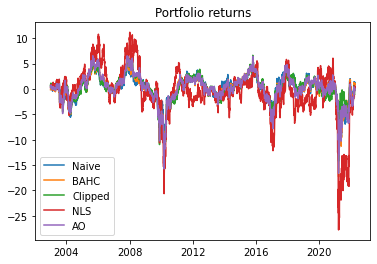

In [337]:
plt.plot(a,outputs['ret'],label = 'Naive')
plt.plot(a,outputs['ret_BAHC'],label='BAHC')
plt.plot(a,outputs['ret_clip'],label = 'Clipped')
plt.plot(a,outputs['ret_NLS'], label = 'NLS')
plt.plot(a,outputs['ret_AO'],label='AO')
plt.title('Portfolio returns')
plt.legend()
plt.show

print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['ret']).mean()},\nEigenvalue clipping:{np.array(outputs['ret_clip']).mean()},\nBAHC:{np.array(outputs['ret_BAHC']).mean()},\nNLS:{np.array(outputs['ret_NLS']).mean()},\nAverage Oracle:{np.array(outputs['ret_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in return terms the following percentage of times: \nEigenvalue clipping:{(np.array(outputs['ret_clip']).flatten()>np.array(outputs['ret'])).mean()},\nBAHC:{(np.array(outputs['ret_BAHC']).flatten()>np.array(outputs['ret'])).mean()},\nNLS:{(np.array(outputs['ret']).flatten()<np.array(outputs['ret_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['ret_AO']).flatten()>np.array(outputs['ret'])).mean()}''')


Mean value for: 
Naive Sigma:3.3022156401228675,
Eigenvalue clipping:2.6427320470773905,
BAHC:3.1012058784467516,
NLS:-0.3878306582285608,
Average Oracle:3.365033143575804


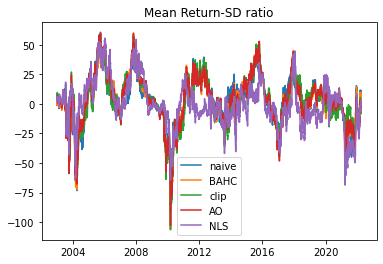

In [338]:
plt.plot(a,outputs['SR'],label='naive')
plt.plot(a,outputs['SR_BAHC'],label='BAHC')
plt.plot(a,outputs['SR_clip'],label='clip')
plt.plot(a,outputs['SR_AO'],label='AO')
plt.plot(a,outputs['SR_NLS'],label='NLS')
plt.legend()
plt.title('Mean Return-SD ratio')

print(f'''Mean value for: \nNaive Sigma:{np.array(outputs['SR']).mean()},\nEigenvalue clipping:{np.array(outputs['SR_clip']).mean()},\nBAHC:{np.array(outputs['SR_BAHC']).mean()},\nNLS:{np.array(outputs['SR_NLS']).mean()},\nAverage Oracle:{np.array(outputs['SR_AO']).mean()}''')

print(f'''\n\nEach method outperform naive method in SR the following percentage of times: \nEigenvalue clipping:{(np.array(outputs['SR_clip']).flatten()>np.array(outputs['SR'])).mean()},\nBAHC:{(np.array(outputs['SR_BAHC']).flatten()>np.array(outputs['SR'])).mean()},\nNLS:{(np.array(outputs['SR']).flatten()<np.array(outputs['SR_NLS'])).mean()},\nAverage Oracle:{(np.array(outputs['SR_AO']).flatten()>np.array(outputs['SR'])).mean()}''')


0.9080459770114943